<a href="https://colab.research.google.com/github/MetronWard/Computer-Vision-Course/blob/main/Chapter_1_Pytorch_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration

In [7]:
import pandas as pd
from typing import Literal

In [8]:
def dataset_fn(train:Literal["train", "test"]):
  match train:
    case "train":
      df = pd.read_csv("/content/sample_data/california_housing_train.csv")
    case "test":
      df = pd.read_csv("/content/sample_data/california_housing_test.csv")

  return df.drop("median_house_value", axis=1), df["median_house_value"].copy()

In [9]:
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [10]:
x, y = dataset_fn(train="train")
y.head(3)

,median_house_value
0,66900.0
1,80100.0
2,85700.0


In [11]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


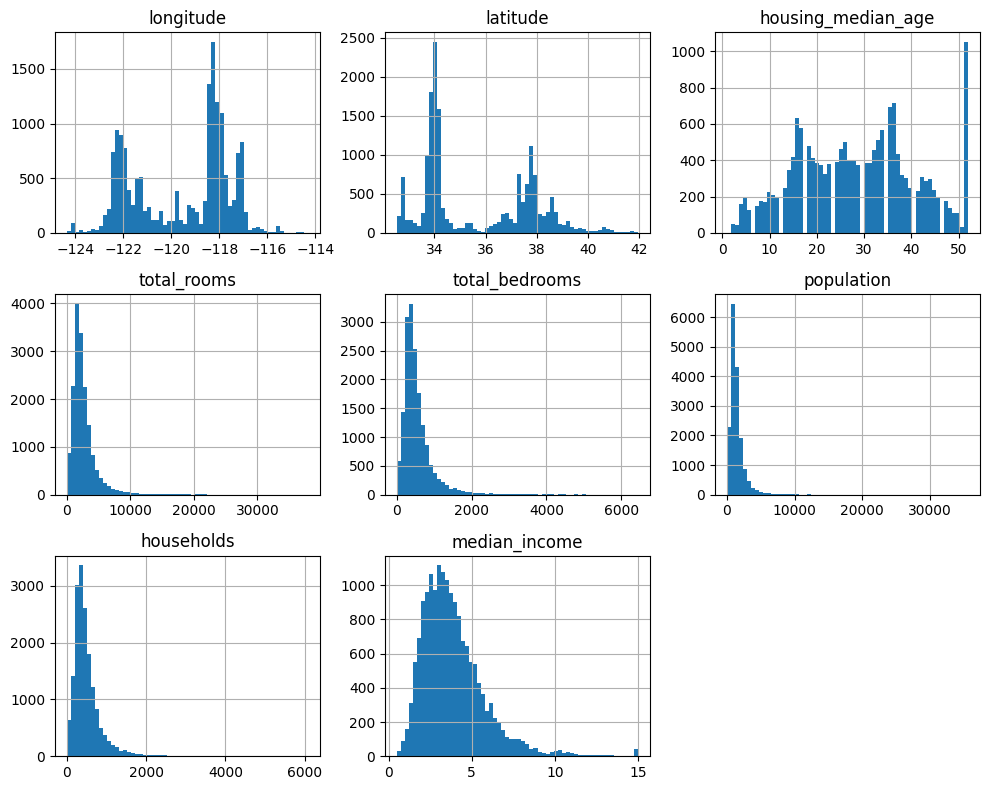

In [12]:
x.hist(figsize=(10, 8), bins=60)
save_fig("attribute_histogram_plots")

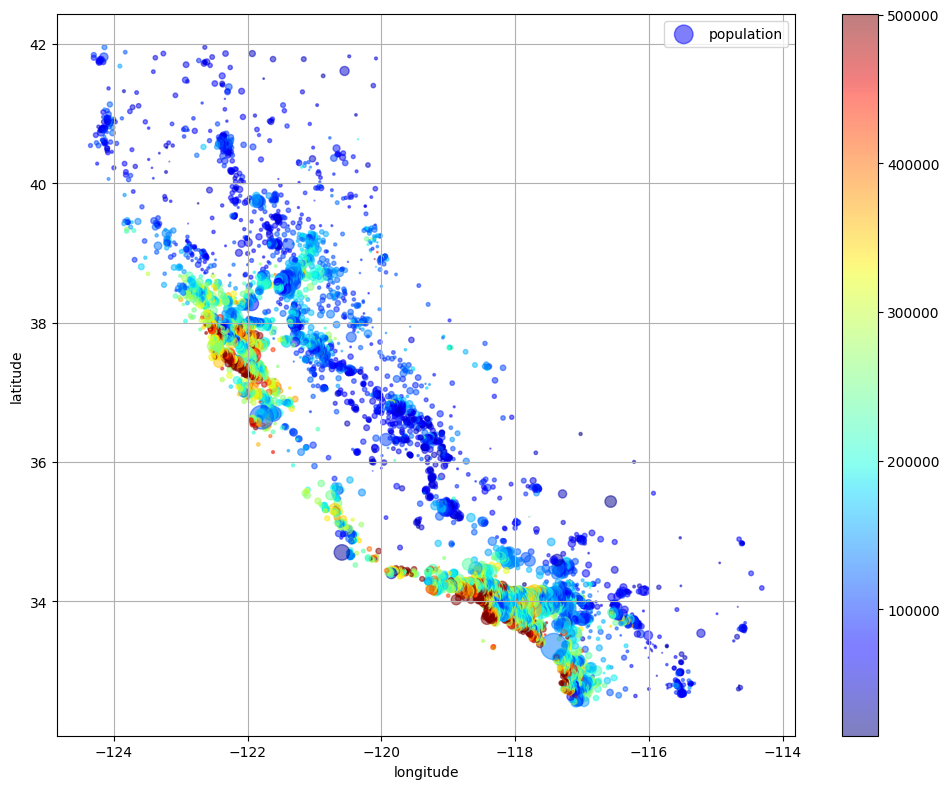

In [13]:
x.plot(kind="scatter", x="longitude", y="latitude", grid=True,
       s=x["population"]/100, label="population", c=y, alpha=0.5,
       cmap="jet", figsize=(10, 8))

save_fig("Geomatric_distribution")

# Dataset

## Splitting into Training and Testing Dataset

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
x_scaler, y_scaler = StandardScaler(), StandardScaler()

In [16]:
x_scaler.fit(x.to_numpy())
y_scaler.fit(y.to_numpy().reshape(-1, 1))

StandardScaler()

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [18]:
print(f"Training Sample --> {len(x_train)}")
print(f"Testing Sample --> {len(x_test)}")

Training Sample --> 11900
Testing Sample --> 5100


## Dataset and DataLoader

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [20]:
class CaliforniaDataset(Dataset):
  def __init__(self, x, y, x_scaler=x_scaler, y_scaler=y_scaler):
    self.x = x_scaler.transform(x.to_numpy()).astype(np.float32)
    self.y = y_scaler.transform(y.to_numpy().reshape(-1, 1)).astype(np.float32)
    self.n_samples = len(self.x)

  def __getitem__(self, index):
    x = self.x[index]
    y = self.y[index]

    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return x, y

  def __len__(self):
    return self.n_samples

In [21]:
train_ds = CaliforniaDataset(
    x=x_train,
    y=y_train
    )

In [22]:
test_ds = CaliforniaDataset(
    x=x_test,
    y=y_test
    )

In [23]:
train_dataloader = DataLoader(dataset=train_ds, batch_size=10, shuffle=True)
test_dataloader = DataLoader(dataset=test_ds, batch_size=10, shuffle=True)

# Defining Model Architecture

In [24]:
import torch.nn as nn

In [25]:
class CaliforniaModel(nn.Module):
  def __init__(self, skeleton:list):
    super().__init__()
    layer_list = []
    for i in range(len(skeleton) -1):
      layer_list.append(nn.Linear(skeleton[i], skeleton[i+1]))
      layer_list.append(nn.BatchNorm1d(skeleton[i+1]))
      layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(skeleton[-1], 1))
    self.model = nn.Sequential(*layer_list)

  def forward(self, x):
    return self.model(x)

In [26]:
model = CaliforniaModel(skeleton=[8, 300, 200, 100, 50, 20])

In [27]:
lr = 5e-5
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [28]:
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=30,
    T_mult=1,
    eta_min=1e-6
)

# Training Loop

In [29]:
from tqdm import trange
import numpy as np

In [30]:
def train_step(model, x, y, criterion, optimizer):
  x, y = x.cpu(), y.cpu()

  optimizer.zero_grad()
  y_hat = model(x)
  loss = criterion(y_hat, y)
  loss.backward()
  optimizer.step()
  lr = optimizer.param_groups[0]["lr"]
  return loss.item(), lr

In [31]:
def test_step(model, x, y, criterion):
  x, y = x.cpu(), y.cpu()

  with torch.no_grad():
    y_hat = model(x)
    loss = criterion(y_hat, y)

  return loss.item()

In [32]:
def fit(model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
        criterion=criterion, optimizer=optimizer,
        scheduler=scheduler, epochs=30):

  df = pd.DataFrame(np.empty([epochs, 4]),
                    index = np.arange(epochs),
                    columns = ["Training Loss", "Testing Loss", "lr", "Epochs"])

  current_test_loss = float("inf")

  for epoch in range(epochs):

    print(f"Epoch {epoch+1}")
    # Training
    model.train()
    progress_bar = trange(len(train_dataloader), desc="Training")

    train_loss = []

    for batch_idx, (x, y) in enumerate(train_dataloader):
        loss, lr = train_step(model, x, y, criterion, optimizer)
        scheduler.step(epoch + batch_idx / len(train_dataloader))

        progress_bar.set_description("Training Loss=%.9f" % loss)
        progress_bar.set_postfix({"lr": lr})
        progress_bar.update(1)
        train_loss.append(loss)
    progress_bar.close()
    mean_train_loss = np.mean(train_loss)


    # Testing
    model.eval()
    test_losses = []

    progress_bar = trange(len(test_dataloader), desc="Testing")

    for batch_idx, (x, y) in enumerate(test_dataloader):
      loss = test_step(model, x, y, criterion)
      test_losses.append(loss)
      progress_bar.set_description("Testing Loss=%.9f" % loss)
      progress_bar.update(1)

    progress_bar.close()
    mean_test_loss = np.mean(test_losses)

    if mean_test_loss < current_test_loss:
      current_test_loss = mean_test_loss
      print(current_test_loss)
      torch.save(model.state_dict(), "Model_state.pth")
      print("Saving Training State....!!!!!")

    scheduler.step()

    df.iloc[epoch, 0] = mean_train_loss
    df.iloc[epoch, 1] = mean_test_loss
    df.iloc[epoch, 2] = optimizer.param_groups[0]["lr"]
    df.iloc[epoch, 3] = epoch + 1

    print(f"Epoch {epoch+1}: Train Loss={mean_train_loss:.6f}, Test Loss={mean_test_loss:.6f}")

  return df

# Fitting Model

In [33]:
model = model.cpu()

In [34]:
df = fit(model=model)

Epoch 1


Testing Loss=0.156166226: 100%|██████████| 510/510 [00:01<00:00, 394.03it/s]


0.18300284032947292
Saving Training State....!!!!!
Epoch 1: Train Loss=0.251069, Test Loss=0.183003
Epoch 2


Testing Loss=0.243041039: 100%|██████████| 510/510 [00:01<00:00, 395.02it/s]


0.159827890075451
Saving Training State....!!!!!
Epoch 2: Train Loss=0.195050, Test Loss=0.159828
Epoch 3


Testing Loss=0.287333578: 100%|██████████| 510/510 [00:01<00:00, 271.27it/s]


0.15135593299626135
Saving Training State....!!!!!
Epoch 3: Train Loss=0.181598, Test Loss=0.151356
Epoch 4


Testing Loss=0.230323151: 100%|██████████| 510/510 [00:02<00:00, 226.72it/s]


Epoch 4: Train Loss=0.176947, Test Loss=0.161734
Epoch 5


Testing Loss=0.109289125: 100%|██████████| 510/510 [00:02<00:00, 231.58it/s]


Epoch 5: Train Loss=0.175128, Test Loss=0.158924
Epoch 6


Testing Loss=0.081545539: 100%|██████████| 510/510 [00:02<00:00, 255.00it/s]


Epoch 6: Train Loss=0.171094, Test Loss=0.160797
Epoch 7


Testing Loss=0.045485210: 100%|██████████| 510/510 [00:01<00:00, 278.39it/s]


0.1461763431418541
Saving Training State....!!!!!
Epoch 7: Train Loss=0.169480, Test Loss=0.146176
Epoch 8


Testing Loss=0.196788579: 100%|██████████| 510/510 [00:01<00:00, 289.19it/s]


0.13588401228189467
Saving Training State....!!!!!
Epoch 8: Train Loss=0.164552, Test Loss=0.135884
Epoch 9


Testing Loss=0.096588135: 100%|██████████| 510/510 [00:01<00:00, 293.99it/s]


Epoch 9: Train Loss=0.162736, Test Loss=0.140663
Epoch 10


Testing Loss=0.116382405: 100%|██████████| 510/510 [00:01<00:00, 316.26it/s]


Epoch 10: Train Loss=0.161750, Test Loss=0.151991
Epoch 11


Testing Loss=0.373991013: 100%|██████████| 510/510 [00:01<00:00, 342.74it/s]


Epoch 11: Train Loss=0.164836, Test Loss=0.145098
Epoch 12


Testing Loss=0.125980198: 100%|██████████| 510/510 [00:02<00:00, 254.31it/s]


Epoch 12: Train Loss=0.160249, Test Loss=0.142531
Epoch 13


Testing Loss=0.078503475: 100%|██████████| 510/510 [00:01<00:00, 273.72it/s]


0.13442906409903776
Saving Training State....!!!!!
Epoch 13: Train Loss=0.159144, Test Loss=0.134429
Epoch 14


Testing Loss=0.184675068: 100%|██████████| 510/510 [00:01<00:00, 268.90it/s]


0.13079763242938355
Saving Training State....!!!!!
Epoch 14: Train Loss=0.156815, Test Loss=0.130798
Epoch 15


Testing Loss=0.164331675: 100%|██████████| 510/510 [00:01<00:00, 283.18it/s]


Epoch 15: Train Loss=0.156514, Test Loss=0.132200
Epoch 16


Testing Loss=0.111475684: 100%|██████████| 510/510 [00:01<00:00, 280.82it/s]


0.12802595019742263
Saving Training State....!!!!!
Epoch 16: Train Loss=0.155949, Test Loss=0.128026
Epoch 17


Testing Loss=0.078118011: 100%|██████████| 510/510 [00:01<00:00, 276.98it/s]


Epoch 17: Train Loss=0.152652, Test Loss=0.136759
Epoch 18


Testing Loss=0.069490977: 100%|██████████| 510/510 [00:01<00:00, 267.73it/s]


Epoch 18: Train Loss=0.154969, Test Loss=0.134417
Epoch 19


Testing Loss=0.144403011: 100%|██████████| 510/510 [00:01<00:00, 256.98it/s]


Epoch 19: Train Loss=0.152613, Test Loss=0.133927
Epoch 20


Testing Loss=0.152249008: 100%|██████████| 510/510 [00:02<00:00, 238.96it/s]


Epoch 20: Train Loss=0.155010, Test Loss=0.132227
Epoch 21


Testing Loss=0.237152264: 100%|██████████| 510/510 [00:02<00:00, 225.27it/s]


0.1274037888383164
Saving Training State....!!!!!
Epoch 21: Train Loss=0.152994, Test Loss=0.127404
Epoch 22


Testing Loss=0.040991455: 100%|██████████| 510/510 [00:02<00:00, 212.39it/s]


Epoch 22: Train Loss=0.150133, Test Loss=0.129612
Epoch 23


Testing Loss=0.213432819: 100%|██████████| 510/510 [00:01<00:00, 262.98it/s]


Epoch 23: Train Loss=0.152915, Test Loss=0.139744
Epoch 24


Testing Loss=0.032680403: 100%|██████████| 510/510 [00:01<00:00, 292.20it/s]


Epoch 24: Train Loss=0.150831, Test Loss=0.128150
Epoch 25


Testing Loss=0.227933794: 100%|██████████| 510/510 [00:01<00:00, 292.58it/s]


Epoch 25: Train Loss=0.149615, Test Loss=0.130687
Epoch 26


Testing Loss=0.023134036: 100%|██████████| 510/510 [00:01<00:00, 330.87it/s]


Epoch 26: Train Loss=0.149765, Test Loss=0.130012
Epoch 27


Testing Loss=0.262418777: 100%|██████████| 510/510 [00:01<00:00, 331.31it/s]


Epoch 27: Train Loss=0.149327, Test Loss=0.139612
Epoch 28


Testing Loss=0.174137443: 100%|██████████| 510/510 [00:01<00:00, 330.15it/s]


Epoch 28: Train Loss=0.154556, Test Loss=0.137778
Epoch 29


Testing Loss=0.084126256: 100%|██████████| 510/510 [00:01<00:00, 337.75it/s]


Epoch 29: Train Loss=0.151246, Test Loss=0.140720
Epoch 30


Testing Loss=0.289539367: 100%|██████████| 510/510 [00:01<00:00, 327.89it/s]


Epoch 30: Train Loss=0.151023, Test Loss=0.131808


## Model Training Inferences

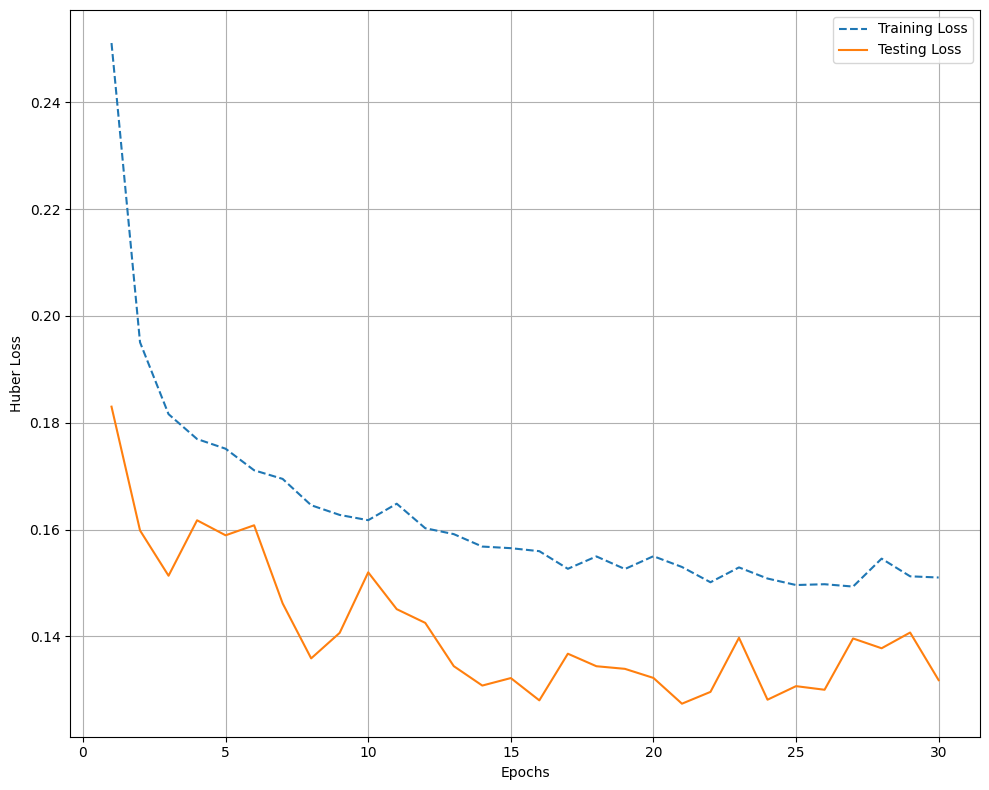

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(df["Epochs"],df["Training Loss"], "--", markersize=3, label="Training Loss")
plt.plot(df["Epochs"],df["Testing Loss"], label="Testing Loss")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Huber Loss")
plt.legend()
save_fig("Training Loop")
# plt.show()

# Model Inference

In [36]:
def test_model(state_dict_path, criterion):
  x,y = dataset_fn(train="test")
  ds = CaliforniaDataset(x, y)
  dataloader = DataLoader(ds, batch_size=10, shuffle=False)

  test_losses = []

  model.load_state_dict(state_dict=torch.load(state_dict_path))
  print("Model Loaded....")

  model.eval()
  progress_bar = trange(len(dataloader), desc="Model Eval")

  for batch, (x,y) in enumerate(dataloader):
    loss = test_step(model, x, y, criterion)
    test_losses.append(loss)
    progress_bar.set_description("Testing Loss=%.9f" % loss)
    progress_bar.update(1)

  progress_bar.close()
  mean_test_loss = np.mean(test_losses)

  return mean_test_loss

In [37]:
mean_loss = test_model(state_dict_path="/content/Model_state.pth", criterion=nn.MSELoss())
corrected_mean_loss = y_scaler.inverse_transform(mean_loss.reshape(-1, 1))

RMSE = np.sqrt(corrected_mean_loss)

Model Loaded....


Testing Loss=0.294275105: 100%|██████████| 300/300 [00:00<00:00, 319.17it/s]


In [38]:
print(f"The final Root Mean Square Loss is ${RMSE[0, 0]}")

The final Root Mean Square Loss is $490.4198972104905


# Model Performance Prediction

In [39]:
x,y = dataset_fn(train="test")

In [40]:
import random

selected_houses = random.sample(list(range(len(x))), 40)

In [41]:
selected_x, selected_y = x.iloc[selected_houses],y.loc[selected_houses]

In [42]:
x.shape

(3000, 8)

In [43]:
def model_preds(state_dict_path, x):
  corrected_x = torch.tensor(x_scaler.transform(x.to_numpy()).astype(np.float32))

  model.load_state_dict(state_dict=torch.load(state_dict_path))

  y = model(corrected_x)

  y_numpy = y.detach().numpy()
  corrected_y = y_scaler.inverse_transform(y_numpy)
  return corrected_y[:, 0]

In [44]:
y_hat = model_preds("/content/Model_state.pth", selected_x)

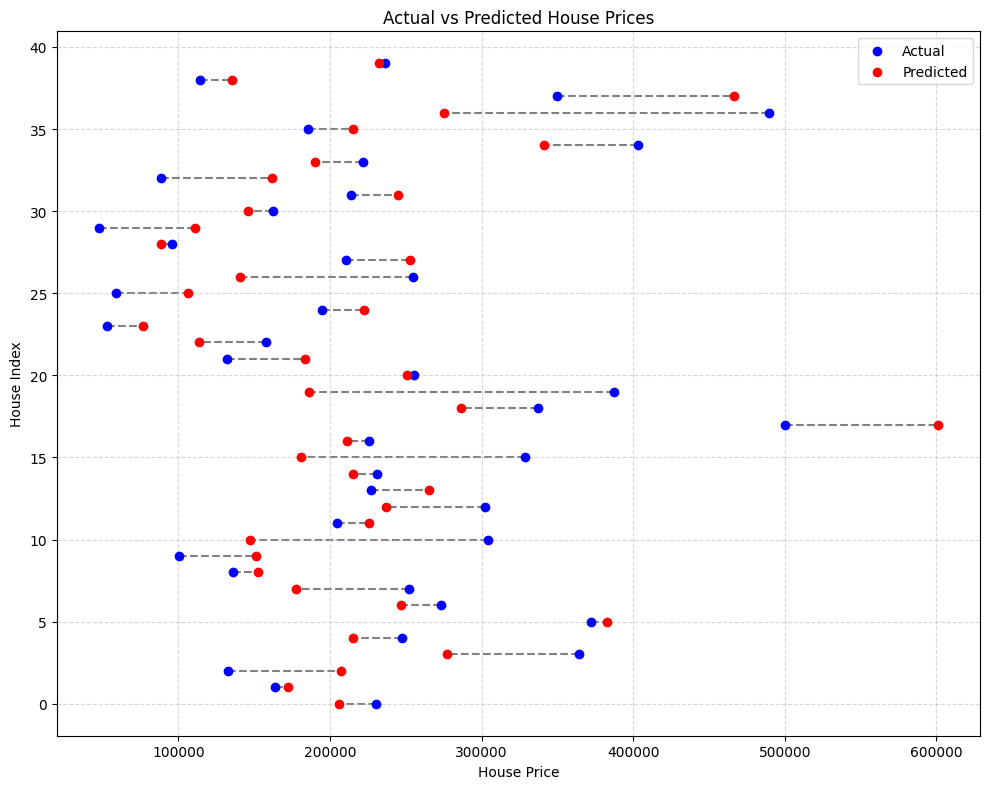

In [45]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(0)
house_indices = np.arange(40)
actual_prices = selected_y.to_numpy()
predicted_prices = y_hat

# Plotting
plt.figure(figsize=(10, 8))

for i in range(len(house_indices)):
    y = house_indices[i]
    # Plot actual price
    plt.scatter(actual_prices[i], y, color='blue', label='Actual' if i == 0 else "", zorder=3)
    # Plot predicted price
    plt.scatter(predicted_prices[i], y, color='red', label='Predicted' if i == 0 else "", zorder=3)
    # # Connect with a line
    plt.plot([actual_prices[i], predicted_prices[i]], [y, y], color='gray', linestyle='--', zorder=1)

plt.xlabel('House Price')
plt.ylabel('House Index')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
save_fig("Model Peformance")